In [1]:
%matplotlib inline
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import clear_output

def affine_transform(input,mat):
    coor=coordinate_one()
    xyzprime=t.tensordot(coor,t.t(mat),dims=1)
    return trilinear(input,xyzprime)

def coordinate_one():
    coor = np.asarray(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z)))
    coor = np.rollaxis(coor, 0, 2)
    coor = np.rollaxis(coor, 0, 3)
    coor = np.rollaxis(coor, 0, 4)
    onesMatrix = np.ones((X, Y, Z, 1))
    coorMatrix = np.concatenate((coor, onesMatrix), axis=3)
    return t.tensor(coorMatrix, device='cuda')

def trilinear(img, xyzprime):
    xp = xyzprime[:, :, :, 0]
    yp = xyzprime[:, :, :, 1]
    zp = xyzprime[:, :, :, 2]
    LUX = t.floor(xp).int()
    LUY = t.floor(yp).int()
    LUZ = t.floor(zp).int()
    LUX = t.where(LUX > X - 2, t.tensor(X - 2, device='cuda'), LUX.long())
    LUX = t.where(LUX < 1, t.tensor(1, device='cuda'), LUX)
    LUY = t.where(LUY > Y - 2, t.tensor(Y - 2, device='cuda'), LUY.long())
    LUY = t.where(LUY < 1, t.tensor(1, device='cuda'), LUY)
    LUZ = t.where(LUZ > Z - 2, t.tensor(Z - 2, device='cuda'), LUZ.long())
    LUZ = t.where(LUZ < 1, t.tensor(1, device='cuda'), LUZ)
    xd, yd, zd = yp - LUY.double(), xp - LUX.double(), zp - LUZ.double()
    k000, k001, k010, k011 = img[LUX, LUY, LUZ], img[LUX, LUY, LUZ + 1], img[LUX, LUY + 1, LUZ], img[
        LUX, LUY + 1, LUZ + 1]
    k100, k101, k110, k111 = img[LUX + 1, LUY, LUZ], img[LUX + 1, LUY, LUZ + 1], img[LUX + 1, LUY + 1, LUZ], img[
        LUX + 1, LUY + 1, LUZ + 1]
    i1 = k000 * (1 - zd) + k001 * zd
    i2 = k010 * (1 - zd) + k011 * zd
    j1 = k100 * (1 - zd) + k101 * zd
    j2 = k110 * (1 - zd) + k111 * zd
    w1 = i1 * (1 - yd) + i2 * yd
    w2 = j1 * (1 - yd) + j2 * yd
    res = w1 * (1 - xd) + w2 * xd
    return res

def affine_transform_3D(input,mat):
    coor=coordinate_one()
    xyzprime=t.tensordot(coor,t.t(mat),dims=1)
    return trilinear(input,xyzprime)


def randxyz(shape, rate):
    np.random.random(shape)
    rst = t.empty(shape).uniform_(0, 1)
    return t.where(rst > t.tensor(rate), t.tensor(0), t.tensor(1))


def np_randxyz(shape, rate):
    rst = np.random.random(shape)
    rst = np.where(rst > rate, 0, 1)
    return t.tensor(rst, device='cuda')


def display_images(image_z, moving, transformed, template):
    plt.subplots(1, 3, figsize=(10, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(moving[image_z, :, :], cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(transformed[image_z, :, :], cmap=plt.cm.Greys_r);
    plt.title('transformed image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(template[image_z, :, :], cmap=plt.cm.Greys_r);
    plt.title('template image')
    plt.axis('off')

    plt.show()
    
def scale(ori, f):
    mov=np.zeros((int(ori.shape[0]/f),int(ori.shape[1]/f),int(ori.shape[2]/f)))
    for i in range(len(ori)):
        if i%f==0:
            for j in range(len(ori[0])):
                if j%f==0:
                    for k in range(len(ori[0][0])):
                        if k%f==0:
                            mov[int(i/2)][int(j/2)][int(k/2)]=ori[i][j][k]
    return mov

In [3]:
import gc
gc.collect()

2458

In [2]:
all=np.load("MRI_3D/OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_rep1.npz")
mov=scale(all["fixed"],2)
# mov=all["fixed"]
mov=t.tensor(mov,device='cuda')
X,Y,Z=mov.shape
matrix=np.array([[1.1,0,0,0],
                 [0,1.1,0,0],
                 [0,0,1.1,0],
                 [0,0,0,1]]).astype('double')
transformMatrix=t.tensor(matrix,device='cuda')
template=affine_transform(mov,transformMatrix)

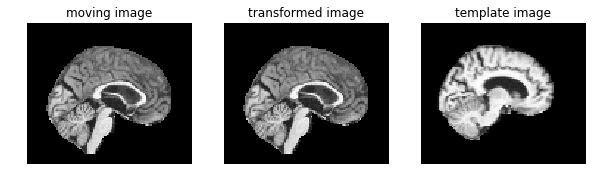

In [7]:
display_images(40,mov.cpu().detach().numpy(),mov.cpu().detach().numpy(),template.cpu().detach().numpy())

In [14]:
import scipy.ndimage
import ipyvolume as ipv
ipv.quickvolshow(template.cpu().detach().numpy())
ipv.show()

D:\Anaconda3\lib\site-packages\ipyvolume\serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [1]:
import numpy as np
import ipyvolume as ipv
V = np.zeros((128,128,128)) # our 3d array
# outer box
V[30:-30,30:-30,30:-30] = 0.75
V[35:-35,35:-35,35:-35] = 0.0
# inner box
V[50:-50,50:-50,50:-50] = 0.25
V[55:-55,55:-55,55:-55] = 0.0
ipv.quickvolshow(V, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
D:\Anaconda3\lib\site-packages\ipyvolume\serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)
